<a href="https://colab.research.google.com/github/DSjeongmin/DSjeongmin/blob/main/Cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 코호트 분석 정의:
    - 코호트 분석(COHORT Analysis)이란 특정 기간 동안 일정한 기준으로 동일한게 묶을 수 있는 사용자들의 집단을 분석하는 기법이다. 가장 흔하게 쓰이는 방법은 특정 날짜를 기준으로 사용자들을 하나의 집단으로 묶어 이들의 행동을 분석하는 것이다.
    
* 코호트 분석을 하는 이유:
    * 가장 핵심적인 것은 왜 고객들을 하나의 집단으로 묶는가를 아는 것이다. 실무적으로는 고객들의 Exit Rate와 Retention Rate(재방문율 혹은 재구매율)을 파악하여 정기적으로 문제를 진단하고, 해결 전략을 도출하기 위한 대시보드로 많이 활용된다.
    * 다른 활용도는 고객집단 별로 고객 생애 가치(LTV, Lifetime Value)를 계산하고, 서비스의 고착도(Stickiness)를 판단할 수 있는 아주 중요한 수단이 된다. 예를 들어 5월 가정의 달 프로모션 때문에 가입한 고객들은 과연 얼마나 서비스에 남아 있고, 총 소비를 얼마나 하는지 궁금할 수도 있다. 이럴 때 코호트 분석을 활용하면, 비즈니스 질문에 가장 최적화된 답을 내놓을 수 있다.

## 코호트 분석 목적 설정

* 코호트 분석은 소비자들을 날짜를 기준으로 동일한 집단으로 묶어주는 분석 기법이다.
* 가장 중요한 것은 무엇을 보기 위해 그들을 하나의 집단으로 묶는가를 명확히 인지하여야 한다.

### 목표 1 : 월별로 소비자들의 재구매율을 판단하여, 2~3달 이내에 가장 많이 이탈한 집단을 발견
### 목표 2 : 소비자 집단별로 수익성을 판단하여, 어떤 Group의 재방문 및 재구매율을 촉진시켜야 하는지 선정

## 사전 준비 작업 진행 - 패키지 및 데이터 불러오기

* 기본 데이터 설명:
    * Order ID: 주문 마다 발생하는 고유의 코드를 의미한다.
    * Order Date: 주문이 발생한 날짜를 의미한다.
    * User ID: 고객마다 갖고 있는 고유의 아이디이다.
    * Total Charge: 주문에서 발생한 총 비용을 의미한다.
    * Command ID부터 pickup date는 쓰지 않을 Column 이기에 넘어가도록 한다.

In [ ]:
import pandas as pd
from pandas import Series
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

df=pd.read_excel('https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx?raw=true',
                 sheet_name='Purchase Data - Full Study', engine='openpyxl')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


## 데이터 전처리
- 전처리 1 : 필요없는 데이터 Column 삭제
- 전처리 2 : 구매주기를 월별로 계산할 수 있게 날짜 형식 치환
    - 월별 소비자 집단을 규정하는 것이기 때문에 date → Month로 바꿔주는 과정을 진행
    - 각 구매가 이루어진 날짜를 "OrderCycle"이라는 열에 삽입

In [ ]:
# 전처리 과정1. 필요 없는 Column들은 Pandas의 Drop Method를 활용

df = df.drop(['CommonId','PupId','PickupDate'],axis=1)


# 전처리 과정2. 우리는 월별 데이터가 목적이기 때문에 데이터 형식을 치환
df['OrderCycle']=df['OrderDate'].dt.strftime('%Y.%m')

df.head()

,OrderId,OrderDate,UserId,TotalCharges,OrderCycle
0,262,2009-01-11,47,50.67,2009.01
1,278,2009-01-20,47,26.60,2009.01
2,294,2009-02-03,47,38.71,2009.02
3,301,2009-02-06,47,53.38,2009.02
4,302,2009-02-06,47,14.28,2009.02


## 코호트 분석에 필요한 변수 생성

In [ ]:
# Group by를 통한 최최 구매일 계산
first_order = df.groupby('UserId').OrderDate.min()
first_order = first_order.dt.strftime('%Y.%m')

# Data Frame의 Index를 User Id로 일시적으로 전환
df = df.set_index('UserId')

# 데이터 First 데이터는 Series + DF는 pandas이기에 Index 기준 자동 병합가능
df['FirstOrder'] = first_order

# Index의 정상화
df.reset_index(inplace = True)

df.head()

,UserId,OrderId,OrderDate,TotalCharges,OrderCycle,FirstOrder
0,47,262,2009-01-11,50.67,2009.01,2009.01
1,47,278,2009-01-20,26.60,2009.01,2009.01
2,47,294,2009-02-03,38.71,2009.02,2009.01
3,47,301,2009-02-06,53.38,2009.02,2009.01
4,47,302,2009-02-06,14.28,2009.02,2009.01


## 월별 구매 고객 데이터 치환
- 1, 주기별 구매한 User의 수 계산
- 2, 주기별 구매한 금액의 계산

In [ ]:
# 주기별 구매 User 계산
co1 = df.groupby(['FirstOrder', 'OrderCycle']).UserId.nunique()
co1 = co1.reset_index()
co1.rename({'UserId': 'TotalUsers'}, axis = 1, inplace = True)

# 주기별 구매 금액 계산
co2 = df.groupby(['FirstOrder', 'OrderCycle']).TotalCharges.sum()
co2 = co2.reset_index()
co2.rename({'TotalCharges': 'PurchaseAmnt'}, axis = 1, inplace = True)

# 데이터 병합
co = co1.merge(co2, on = ['FirstOrder', 'OrderCycle'])
co.head()

,FirstOrder,OrderCycle,TotalUsers,PurchaseAmnt
0,2009.01,2009.01,22,1850.255
1,2009.01,2009.02,8,1351.065
2,2009.01,2009.03,10,1357.360
3,2009.01,2009.04,9,1604.500
4,2009.01,2009.05,10,1575.625


## 코호트 기간 기준 계산 및 데이터 형태 최종 구축

In [ ]:
from ipypb import ipb
temp = []

for i in ipb(range(co.shape[0])):
    f_first_order = pd.to_datetime(co.FirstOrder[i]).to_period('M')
    f_order_cycle = pd.to_datetime(co.OrderCycle[i]).to_period('M')

    month_diff = (f_order_cycle - f_first_order).n

    temp.append(month_diff)
co['CohortPeriod'] = temp

co.head()

 [████████████████████████████████████████████████████████████] 119/119 [00:00<00:00, 0.00s/it]

,FirstOrder,OrderCycle,TotalUsers,PurchaseAmnt,CohortPeriod
0,2009.01,2009.01,22,1850.255,0
1,2009.01,2009.02,8,1351.065,1
2,2009.01,2009.03,10,1357.360,2
3,2009.01,2009.04,9,1604.500,3
4,2009.01,2009.05,10,1575.625,4


In [ ]:
## 첫 번째. 재방문율 계산을 위한 Pandas Unstack 활용
co_retention = co.set_index(['FirstOrder', 'CohortPeriod'])
co_retention = co_retention.TotalUsers.unstack(1)
retention = co_retention.div(co_retention[0],axis = 0)

## 두 번째. 구매 규모 형태 치환을 위한 Pandas Unstack 활용
co_purchase = co.set_index(['FirstOrder', 'CohortPeriod'])
co_purchase = co_purchase.PurchaseAmnt.unstack(1)

## 코호트 분석 시각화

### 재방문율 시각화

<AxesSubplot:xlabel='CohortPeriod', ylabel='FirstOrder'>

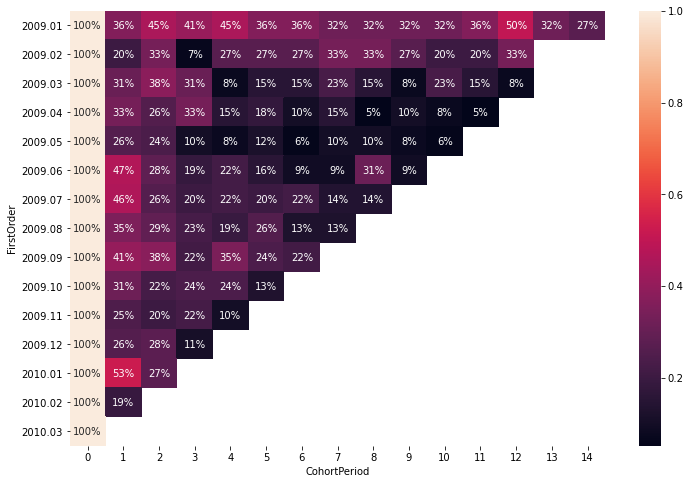

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## 재방문율 시각화 진행
plt.rcParams['figure.figsize'] = (12, 8)
sns.heatmap(retention, annot = True, fmt = '.0%')


### 구매 규모 시각화

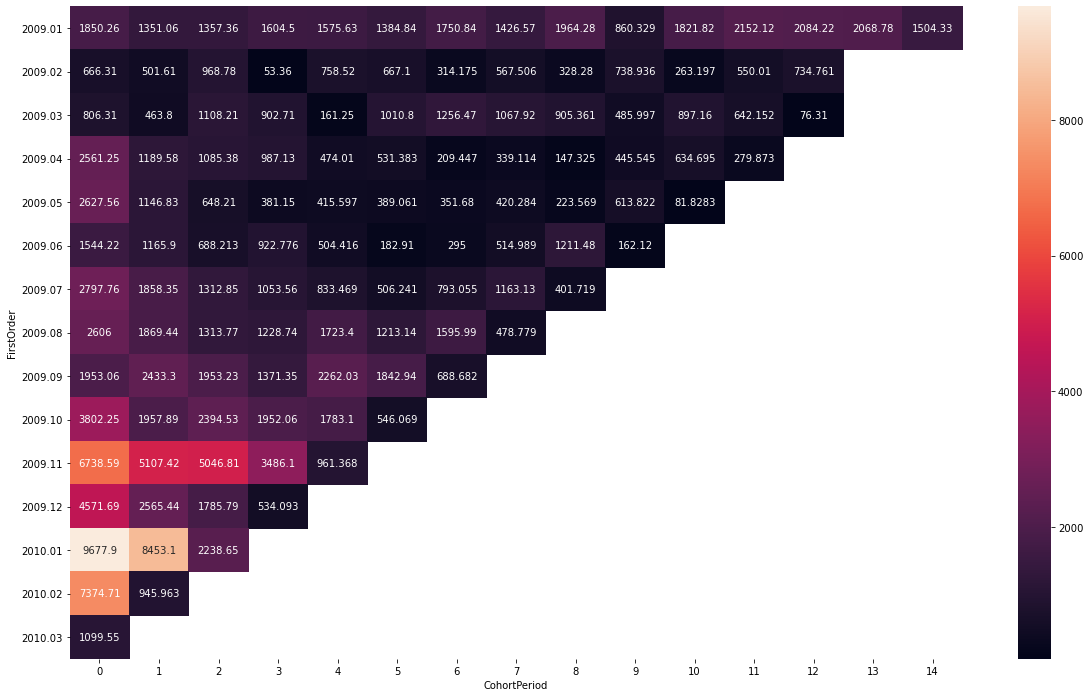

In [ ]:
## 구매 규모 시각화
plt.rcParams['figure.figsize'] = (20, 12)
sns.heatmap(co_purchase, annot = True
            , fmt = 'g'
           )

plt.yticks(rotation = 360);

## 해석
- 목표1. 월별 소비자 집단 중 이탈이 가장 많은 집단 파악
    - 코호트 기간을 1로 고정해 놓고 봤을 때 가장 이탈률이 높은 집단 순위를 산출해보겠다.
        - 2010년 2월 - 재구매율 19%
        - 2009년 2월 - 재구매율 20%
        - 2009년 11월 - 재구매율 25%
        - 2009년 5월 - 재구매율 26%
        - 2009년 12월 - 재구매율 26%

- 목표2. 수익성 기반 Retention을 재고해야 할 집단 선정
    - 2010년 1월 - 약 9천 달러
    - 2010년 2월 - 약 7천 달러
    - 2009년 11월 - 약 6천 7백 달러

- 위의 두 가지 결과를 봤을 때 눈에 들어오는 것은 2010년 2월달 구매자들이다. 구매 규모만 놓고 보면, 2순위로 기록될 만큼 굉장히 큰 구매력이 있는 집단이다. 그러나 재방문율을 놓고 봤을 때 이탈이 가장 많이 된 집단이기도 하다. 따라서 현재 2010년 2월에 굉장히 매출이 잘 나왔다하더라도, 이 고객들이 서비스에 남아있지 않고 이탈하여 장기적인 수익을 놓치고 있는 상황이라는 것을 유추해볼 수 있다